In [39]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

from custom_functions import *

save_format = "svg"

# Load data

## Bulk gastruloid
For this analysis, we will only retain the samples from the 72h and the initial condition at 48h, immediately before Chiron treatment.

In [40]:
df_gastruloid = pd.read_csv("data/gastruloid_bulk.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
df_gastruloid_metadata = pd.read_csv("data/gastruloid_bulk_metadata.csv",index_col=1)

# Analysis

## Scaling

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [41]:
df1 = df_gastruloid.copy()
df1 = df1.div(df1.sum(axis=1), axis=0)*10E6
df1 = np.log1p(df1)
df1.fillna(0,inplace=True)

## Feature selection

We select the most varying genes of both datasets and find the common number between both datasets. We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [42]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

len(l)

730

## PCA

In [43]:
fs = VarianceThreshold(threshold=.8)
fs.fit(df1.values)

print("Retained: ",len(fs.get_feature_names_out()))

Retained:  1187


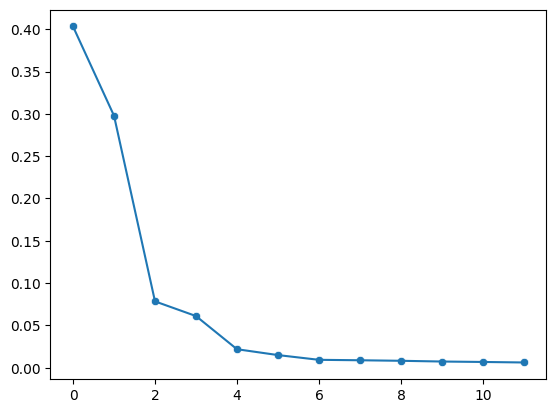

In [44]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
pca = PCA(n_components=12)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

plt.savefig(f"results/bulk_analysis_pca_explained_variance.{save_format}",bbox_inches="tight",transparent=True)

In [45]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(4,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

### Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

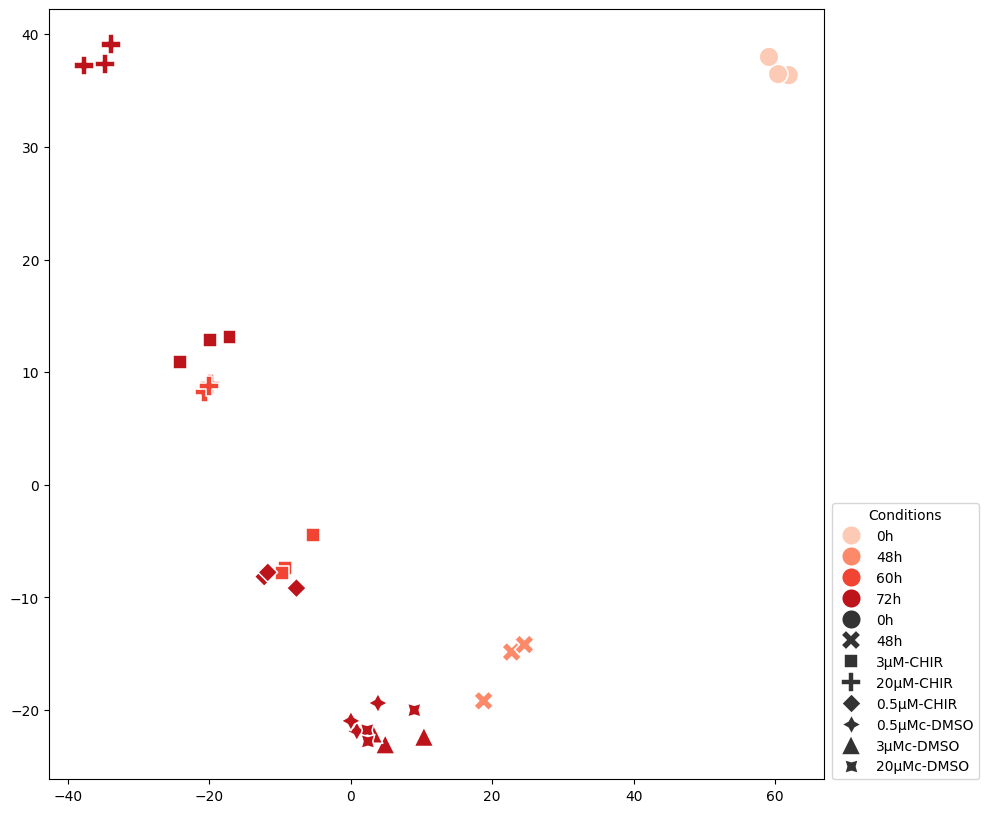

In [46]:
fig,ax = plt.subplots(figsize=(10,10))

x = pca.transform(fs.transform(df1.values))
p = sns.scatterplot(x=x[:,0],y=x[:,1],
                style=[i.split("_")[-1] for i in df_gastruloid_metadata["Condition"].values],
                hue=df_gastruloid_metadata["Timepoint"],
                s=200,palette="Reds")

ax.legend(loc=(1.01,0),title="Conditions")

plt.savefig(f"results/bulk_analysis_pca_scatterplot.{save_format}",bbox_inches="tight",transparent=True)

### Loadings

This shows that buttom-left to up-right is capturing changes in genes like (T, Wnt3a, etc.) and up-left to bottom-right capturing expressioon of genes like (Hox-family).

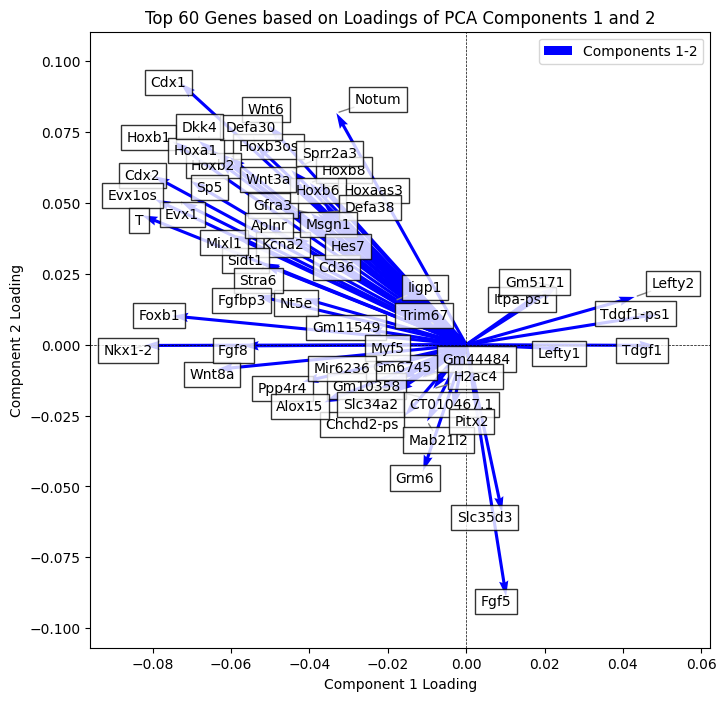

<Figure size 640x480 with 0 Axes>

In [47]:
plot_loadings_components(pca,0,1,df1_fs.columns.values,60)

plt.savefig(f"results/bulk_analysis_pca_loadings.{save_format}",bbox_inches="tight",transparent=True)